# ==================== Libraries =============================

In [1]:
import os
import torch
from torch import nn
import argparse, math, time, json
import numpy as np
import pandas as pd

from torchsummary import summary
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import accuracy_score

# ====================== Create model =======================

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers,bath_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.bath_size   = bath_size

        self.lstm     = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=True)
        self.ho      = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, S, hidden,C):
        
        output,H_C = self.lstm(S, (hidden,C))
        
        output = self.ho(output)
        output = self.softmax(output)
        return output, H_C

    def initHidden(self,bath_size):
        return torch.zeros(self.num_layers*2, bath_size,self.hidden_size), torch.zeros(self.num_layers*2, bath_size,self.hidden_size)

# ====================== Functions ============================

In [3]:
def batch_prediction(lstm,batch_data):
    sequence       = torch.from_numpy(batch_data).transpose_(0, 1).float().to(device)

    hidden,C       = lstm.initHidden(sequence.shape[1])
    output, H_C    = lstm(sequence, hidden.to(device),C.to(device))
    
    labels_pred = []
    for k in range(output.shape[1]):
        labels_pred.append(torch.argmax(output[:,k,:],axis=-1).cpu().numpy())
        
    return labels_pred

In [4]:
def prediction(lstm,data):
    labels_pred = []
    ll          = [i for i in range(0,len(data),bath_size)]
    for el,j in enumerate(ll):
        if j<ll[-1]:
            s = j
            e = j+bath_size
            batch_data     = np.stack(data[s:e])
        elif j==ll[-1]:
            s = j
            e = len(data)-1
            batch_data     = np.stack(data[s:e])
        
        labels_pred.extend(batch_prediction(lstm,batch_data))
        #print(s,e,labels_pred[-1].shape)
    
    batch_data     = np.expand_dims(np.stack(data[-1]),axis=1)
    labels_pred.extend(batch_prediction(lstm,batch_data))
    #print(labels_pred[-1].shape)
    labels_pred = np.concatenate(labels_pred)   
    return labels_pred

In [5]:
def data_sequence(data):
    new_data = []
    ll        = [i for i in range(0,data.shape[0],seq_l)]
    for j in ll:
        if j==ll[-1]:
            s = j
            e = data.shape[0]
        else:
            s = j
            e = j+seq_l
        new_data.append(data[s:e])
    return new_data

In [6]:
def labels_sequence(labels):
    new_labels = []
    ll        = [i for i in range(0,labels.shape[0],seq_l)]
    for j in ll:
        if j==ll[-1]:
            s = j
            e = labels.shape[0]
        else:
            s = j
            e = j+seq_l
        new_labels.append(labels[s:e])
    return new_labels

In [7]:
def create_features(vec_s,nb_feat):
    train_data = np.zeros((vec_s.shape[0],2*nb_feat+1))
    
    vec_s = np.concatenate([np.zeros(nb_feat),vec_s,np.zeros(nb_feat)], axis=0)   
    for i in range(train_data.shape[0]):
        train_data[i,:] = vec_s[i:i+2*nb_feat+1]
    return train_data

# =================== Parameters and input ===================

In [8]:
nb_feat     = 2
seq_l       = 5
bath_size   = 32

input_size  = 2*nb_feat+1
hidden_size = 8
num_layers  = 5


Nb_epochs   = 5
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn

criterion = nn.CrossEntropyLoss()

# ========================= Main ============================

In [9]:
# train_clean_data = pd.read_csv('train_clean_kalman.csv').to_numpy()
# test_clean_data  = pd.read_csv('test_clean_kalman.csv').to_numpy()

# train_x      = train_clean_data[:,1]
# train_y      = train_clean_data[:,-1].astype(int)

# test_x      = test_clean_data[:,-1]
# labels_test = np.load('labels_test.npy')

In [10]:
train_x      = np.load('train_x.npy')
train_y      = np.load('train_y.npy')

test_x      = np.load('test_x.npy')
labels_test = np.load('labels_test.npy')

In [11]:
train_data = create_features(train_x,nb_feat)
test_data  = create_features(test_x,nb_feat)

In [12]:
labels_train = np.zeros(train_data.shape[0])
for idx in range(train_data.shape[0]):
    if idx<1000000:
        labels_train[idx] = 0
    elif (idx>=1000000 and idx<1500000) or (idx>=3000000 and idx<3500000):
        labels_train[idx] = 1
    elif (idx>=1500000 and idx<2000000) or (idx>=3500000 and idx<4000000):
        labels_train[idx] = 2
    elif (idx>=2000000 and idx<2500000) or (idx>=4500000 and idx<5000000):
        labels_train[idx] = 3
    elif (idx>=2500000 and idx<3000000) or (idx>=4000000 and idx<4500000):
        labels_train[idx] = 4

# =============== train model for every groupe ===================

In [13]:
channel_pred = labels_test
for i in range(5):
    train_inds = np.where(labels_train==i)[0]
    test_inds  = np.where(labels_test[:,1]==i)[0]
    
    X_g_train = train_data[train_inds]
    Y_g_train = train_y[train_inds]
    X_g_test  = test_data[test_inds]

    ############################### prepare the data in format of sequences #############################
    X_g_train1 = data_sequence(X_g_train)
    Y_g_train1  = labels_sequence(Y_g_train)
    X_g_test1  = data_sequence(X_g_test)
    
    ####################################### create model and optimizer ################################
    output_size = Y_g_train.max()+1
    lstm        = LSTM(input_size, hidden_size, output_size,num_layers,bath_size)
    device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lstm.to(device)
    optimizer   = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    
    ############################################# Train model ########################################
    train_acc = []
    Loss      = np.zeros(Nb_epochs)
    for k in range(Nb_epochs):
        lstm.train()
        L = 0
        ll        = [i for i in range(1,len(X_g_train1),bath_size)]
        for el,j in enumerate(ll):
            if j==ll[-2]:
                s = j
                e = len(X_g_train1)-1
            elif j<ll[-2]:
                s = j
                e = j+bath_size
            else:
                s = len(X_g_train1)-1
                e = len(X_g_train1)
            
            batch_data     = np.stack(X_g_train1[s:e])
            batch_label    = np.stack(Y_g_train1[s:e])
            
            sequence       = torch.from_numpy(batch_data).transpose_(0, 1).float().to(device)
            sequence_label = torch.from_numpy(batch_label).transpose_(0, 1).type(torch.LongTensor).to(device)
            
            hidden,C       = lstm.initHidden(sequence.shape[1])
            output, H_C    = lstm(sequence, hidden.to(device),C.to(device))
            loss = torch.zeros(output.shape[1]).to(device)
            for n in range(output.shape[1]):
                l = criterion(output[:,n,:], sequence_label[:,n])
                loss[n] = l
            loss = torch.mean(loss)    
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly

            L = L+loss.item()
            if el%1000==0:
                print(output.shape,sequence_label.shape)
                print(j)

        print('#####################################################################################################',i,k)
    
    lstm.eval()
    test_pred  = prediction(lstm,X_g_test1)
    channel_pred[test_inds,1] = test_pred
    

torch.Size([5, 32, 2]) torch.Size([5, 32])
1
torch.Size([5, 32, 2]) torch.Size([5, 32])
32001
torch.Size([5, 32, 2]) torch.Size([5, 32])
64001
torch.Size([5, 32, 2]) torch.Size([5, 32])
96001
torch.Size([5, 32, 2]) torch.Size([5, 32])
128001
torch.Size([5, 32, 2]) torch.Size([5, 32])
160001
torch.Size([5, 32, 2]) torch.Size([5, 32])
192001
##################################################################################################### 0 0
torch.Size([5, 32, 2]) torch.Size([5, 32])
1
torch.Size([5, 32, 2]) torch.Size([5, 32])
32001
torch.Size([5, 32, 2]) torch.Size([5, 32])
64001
torch.Size([5, 32, 2]) torch.Size([5, 32])
96001
torch.Size([5, 32, 2]) torch.Size([5, 32])
128001
torch.Size([5, 32, 2]) torch.Size([5, 32])
160001
torch.Size([5, 32, 2]) torch.Size([5, 32])
192001
##################################################################################################### 0 1
torch.Size([5, 32, 2]) torch.Size([5, 32])
1
torch.Size([5, 32, 2]) torch.Size([5, 32])
32001
torch.Size

torch.Size([5, 32, 11]) torch.Size([5, 32])
64001
torch.Size([5, 32, 11]) torch.Size([5, 32])
96001
torch.Size([5, 32, 11]) torch.Size([5, 32])
128001
torch.Size([5, 32, 11]) torch.Size([5, 32])
160001
torch.Size([5, 32, 11]) torch.Size([5, 32])
192001
##################################################################################################### 3 3
torch.Size([5, 32, 11]) torch.Size([5, 32])
1
torch.Size([5, 32, 11]) torch.Size([5, 32])
32001
torch.Size([5, 32, 11]) torch.Size([5, 32])
64001
torch.Size([5, 32, 11]) torch.Size([5, 32])
96001
torch.Size([5, 32, 11]) torch.Size([5, 32])
128001
torch.Size([5, 32, 11]) torch.Size([5, 32])
160001
torch.Size([5, 32, 11]) torch.Size([5, 32])
192001
##################################################################################################### 3 4
torch.Size([5, 32, 6]) torch.Size([5, 32])
1
torch.Size([5, 32, 6]) torch.Size([5, 32])
32001
torch.Size([5, 32, 6]) torch.Size([5, 32])
64001
torch.Size([5, 32, 6]) torch.Size([5, 32])


# ====================== write the results =====================

In [14]:
inds = np.where(channel_pred[:,1]<0)[0]
channel_pred[inds,1] = 0
channel_pred[:,1] = np.round(channel_pred[:,1])

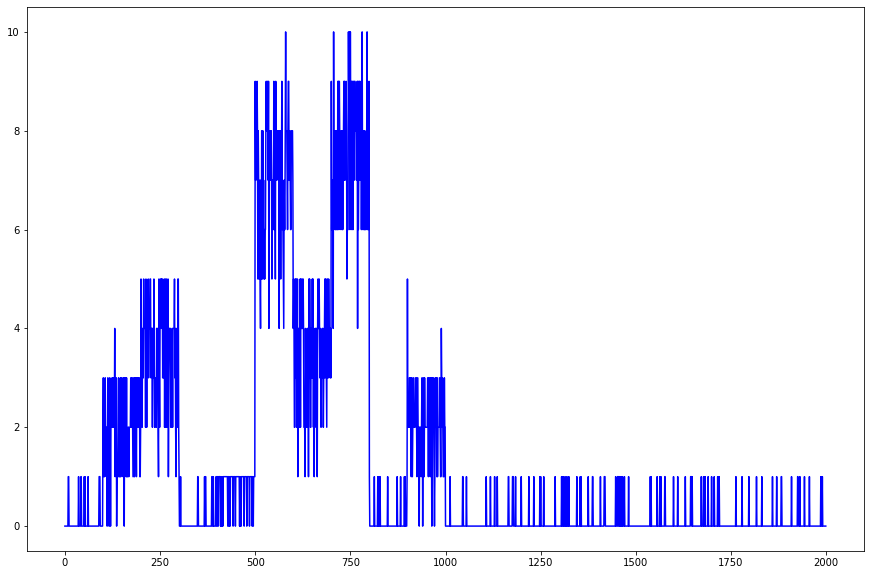

In [15]:
plt.figure(figsize=(15,10))
plt.plot(channel_pred[::1000,1],'b')

In [16]:
np.save('channel_pred',channel_pred)

In [17]:
time = pd.read_csv("sample_submission.csv").to_numpy()
with open("samples_submition.csv", "w+") as f:
    f.write("time,open_channels\n")
    for t,p in zip(time[:,0],channel_pred[:,1]):
        f.write("{:.4f},{}\n".format(t,int(p)))